In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

C:\Users\mrkawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [2]:
# Read raw data - from local file if available, else from internet and write to local file
if os.path.exists('data/data.csv.gz'):
    dfFull = pd.read_csv('data/data.csv.gz', compression='gzip',index_col=0)
elif os.path.exists('../data/data.csv.gz'):
    dfFull = pd.read_csv('../data/data.csv.gz', compression='gzip',index_col=0)
else:
    YEARS = np.arange(1999,date.today().year)
    dfFull = pd.DataFrame()
    for i in YEARS:
        sys.stdout.write(f'{i} \r'); sys.stdout.flush()
        iData = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                             'play_by_play_' + str(i) + '.csv.gz?raw=True',
                             compression='gzip', low_memory=False)
        dfFull = dfFull.append(iData, sort=True)

    dfFull.reset_index(drop=True, inplace=True)
    dfFull.to_csv('../data/data.csv.gz', compression='gzip')

C:\Users\mrkawa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,12,13,14,15,16,23,24,62,63,79,80,81,93,94,95,100,101,102,132,133,134,135,136,137,138,139,144,145,150,157,158,164,165,166,167,184,204,205,206,207,219,249,250,251,255,257,260,261,262,263,306,310) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [646]:
# Lookup table with all features of the raw data
featureInfo = pd.read_csv('features.csv').iloc[:,0:4]
# print(featureInfo[featureInfo.Use==1])

idCols = featureInfo[(featureInfo.Use==1) & (featureInfo.Type == 'ID')].Field.tolist() + ['receiver_player_name']
valCols = featureInfo[(featureInfo.Use==1) & (featureInfo.Type != 'ID')].Field.tolist() + ['season', 'game_id'] 
notUsed = [col for col in d.columns if col not in idCols + valCols]
df = dfFull[['season'] + [x for x in featureInfo[(featureInfo.Use==1)].Field] + ['receiver_player_name','rusher_player_name']]
                                                                                 
def lookup(s):
    return featureInfo[featureInfo.Field.str.contains(s)]

# Flex, Full Season Projections
## Season total stats only

In [790]:
# Filter to relevant plays
df = df.dropna(subset=['receiver_player_name','rusher_player_name'], how='all')#[df.season>=2011]

df['player_name'] = df.receiver_player_name.fillna(df.rusher_player_name)
df['rec_yards'] = df.pass_attempt * df.yards_gained
df['rush_yards'] = df.rush_attempt * df.yards_gained

In [791]:
# Sum all metrics per player per season
seasonTotals = df.groupby(['season','player_name']).sum().drop(['play_id','qb_scramble','sack','safety'],axis=1)

# seasonTotals.describe().transpose()[['min','max','mean','std']] #df info
seasonTotals.columns

Index(['complete_pass', 'fumble', 'incomplete_pass', 'interception',
       'no_huddle', 'pass_attempt', 'pass_touchdown', 'qb_dropback', 'qb_hit',
       'rush_attempt', 'rush_touchdown', 'shotgun', 'tackled_for_loss',
       'touchdown', 'air_yards', 'yards_after_catch', 'yards_gained',
       'rec_yards', 'rush_yards'],
      dtype='object')

In [792]:
# Calculate fantasy points
if not 'fanPts' in seasonTotals.columns:
    seasonTotals.insert(0,'fanPts',0)

ppr = 0
seasonTotals.fanPts = seasonTotals.yards_gained/10 + seasonTotals.touchdown*6 - 2*seasonTotals.fumble + seasonTotals.complete_pass*ppr

In [804]:
# Append data from N previous seasons as new columns 
seasonHist = seasonTotals.copy()
currentYear = 2019
lookback = 3
for i in range(1,lookback+1):
    temp = seasonTotals.copy().reset_index()
    temp = temp[temp.season.isin(range(1999,currentYear-i+1))]
    temp['season'] = temp.season+i
    seasonHist = seasonHist.join(temp.set_index(['season','player_name']),how='outer',rsuffix=f'-{i}')

# Remove no longer active players
seasonHist = seasonHist.dropna(subset=['fanPts'])

In [808]:
# Partition training, dev, and test data
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

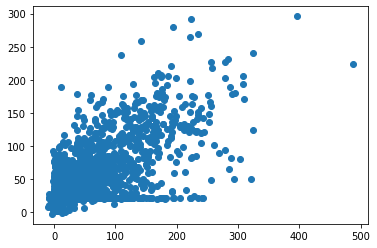

MSE: 1941.8
R^2: 0.48


,touchdown-1,fumble-1,fanPts-1,yards_gained-1,rush_yards-1,rec_yards-1,rush_yards-3,rec_yards-3,yards_gained-3,yards_gained-2,rec_yards-2,rush_yards-2,rush_touchdown-3,interception-3,pass_touchdown-3,pass_attempt-3,rush_touchdown-1,complete_pass-3,pass_touchdown-2,incomplete_pass-3,pass_touchdown-1,rush_touchdown-2,incomplete_pass-1,complete_pass-1,pass_attempt-1,interception-1,interception-2,fumble-2,fumble-3,pass_attempt-2,touchdown-2,tackled_for_loss-1,complete_pass-2,qb_hit-1,fanPts-3,qb_hit-2,incomplete_pass-2,qb_hit-3,fanPts-2,qb_dropback-3,tackled_for_loss-2,qb_dropback-1,rush_attempt-1,touchdown-3,no_huddle-1,rush_attempt-3,rush_attempt-2,no_huddle-3,qb_dropback-2,no_huddle-2,shotgun-3,yards_after_catch-2,shotgun-1,tackled_for_loss-3,yards_after_catch-1,yards_after_catch-3,air_yards-2,air_yards-1,air_yards-3,shotgun-2
1,-128899570281.644,42966523425.276,21483261713.218,-2148326196.552,25.360,25.311,17.929,17.921,-17.827,9.307,-9.233,-9.223,5.077,-4.265,4.204,4.010,3.955,-3.739,3.730,-3.660,3.490,2.615,2.469,2.449,-2.105,2.042,1.865,-1.830,-1.231,-0.954,-0.838,0.819,0.743,-0.725,-0.719,-0.660,0.544,0.505,-0.437,-0.388,0.371,-0.342,-0.316,-0.234,-0.142,-0.113,-0.109,-0.099,0.063,-0.053,-0.044,0.023,0.021,0.017,-0.014,-0.009,0.008,0.008,-0.007,-0.001


In [809]:
# Linear regression model 0
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

plt.scatter(y_test, y_pred)
plt.show()

print(f'MSE: {mean_squared_error(y_test, y_pred).round(1)}')
print(f'R^2: {r2_score(y_test, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

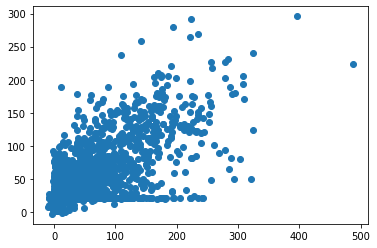

MSE: 1940.9
R^2: 0.48


,rush_yards-1,rec_yards-1,yards_gained-1,rush_yards-3,rec_yards-3,yards_gained-3,yards_gained-2,rec_yards-2,rush_yards-2,rush_touchdown-3,interception-3,pass_touchdown-3,pass_attempt-3,rush_touchdown-1,pass_touchdown-2,complete_pass-3,incomplete_pass-3,pass_touchdown-1,rush_touchdown-2,incomplete_pass-1,complete_pass-1,pass_attempt-1,interception-1,interception-2,fumble-1,fumble-2,fumble-3,pass_attempt-2,touchdown-2,tackled_for_loss-1,complete_pass-2,qb_hit-1,fanPts-3,qb_hit-2,incomplete_pass-2,qb_hit-3,fanPts-2,qb_dropback-3,tackled_for_loss-2,qb_dropback-1,fanPts-1,rush_attempt-1,touchdown-1,touchdown-3,no_huddle-1,rush_attempt-3,rush_attempt-2,no_huddle-3,qb_dropback-2,no_huddle-2,shotgun-3,yards_after_catch-2,shotgun-1,tackled_for_loss-3,yards_after_catch-1,yards_after_catch-3,air_yards-2,air_yards-1,air_yards-3,shotgun-2
1,22.617,22.567,-22.453,15.555,15.547,-15.454,8.423,-8.349,-8.339,5.066,-4.223,4.193,3.970,3.937,3.707,-3.700,-3.620,3.476,2.593,2.469,2.446,-2.102,2.035,1.845,-1.833,-1.826,-1.216,-0.936,-0.822,0.818,0.728,-0.724,-0.712,-0.662,0.527,0.505,-0.437,-0.389,0.369,-0.343,-0.338,-0.316,-0.293,-0.266,-0.141,-0.113,-0.109,-0.099,0.062,-0.053,-0.044,0.023,0.021,0.019,-0.013,-0.009,0.008,0.008,-0.007,-0.002


In [810]:
# Ridge regression model 0
regr = linear_model.Ridge()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

plt.scatter(y_test, y_pred)
plt.show()

print(f'MSE: {mean_squared_error(y_test, y_pred).round(1)}')
print(f'R^2: {r2_score(y_test, y_pred).round(2)}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs